# Embedding de exemplo

**Descrição:**
Este notebook apresenta um exemplo mínimo e didático de como construir e treinar embeddings de palavras usando PyTorch a partir de um corpus pequeno em português (frases sobre gato, cachorro, aranha e alguns objetos do ambiente). O foco é manter o pipeline simples e reproduzível: tokenização por palavras, criação de vocabulário, geração de pares de treino (contexto → alvo) e treinamento de uma camada `nn.Embedding`.

**Objetivo:**
1. Criar um vocabulário (token → id e id → token) a partir do corpus fornecido.  
2. Treinar embeddings de palavras com um modelo simples (CBOW) para obter vetores já “aprendidos”.  
3. Salvar corpus, vocabulário, configurações e logs em `../../data/...` e os embeddings em `../../models/...`.  
4. Visualizar as palavras em um scatter plot (2D) para apoiar explicações posteriores sobre a camada de atenção.

**Funcionamento:**
- **Tokenização:** cada frase do corpus é convertida em uma sequência de palavras (tokens), removendo pontuação e padronizando para minúsculas.  
- **Vocabulário:** todos os tokens únicos são coletados e mapeados para inteiros (IDs).  
- **Dataset (CBOW):** para cada palavra-alvo, montamos seu contexto (janela de palavras ao redor) e treinamos o modelo para prever a palavra-alvo a partir da média dos embeddings do contexto.  
- **Treinamento:** a camada `nn.Embedding` é otimizada via backpropagation usando `CrossEntropyLoss`, produzindo vetores que capturam relações simples do corpus.  
- **Persistência e visualização:** os artefatos principais são salvos em disco e, ao final, os embeddings (em 2D) são plotados para inspeção visual e uso em etapas futuras (atenção/self-attention).

In [1]:
import json
import csv
import re
from dataclasses import asdict, dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


# Pastas (conforme sua exigência)
DATA_DIR = Path("../../data/mini_corpus_attn")
MODELS_DIR = Path("../../models/mini_corpus_attn")

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_DIR :", DATA_DIR.resolve())
print("MODELS_DIR:", MODELS_DIR.resolve())

# Reprodutibilidade
torch.manual_seed(42)

DATA_DIR : C:\Users\Enacom\Documents\GitHub\build_llm\data\mini_corpus_attn
MODELS_DIR: C:\Users\Enacom\Documents\GitHub\build_llm\models\mini_corpus_attn


## Corpus

In [2]:
corpus = [
    # Gato
    "O gato sobe no tapete.",
    "O gato desce do tapete.",
    "O gato sobe na mesa.",
    "O gato desce da mesa.",
    # Cachorro
    "O cachorro sobe no tapete.",
    "O cachorro desce do tapete.",
    "O cachorro sobe na mesa.",
    "O cachorro desce da mesa.",
    # Aranha
    "A aranha sobe na parede.",
    "A aranha desce da parede.",
    # Objetos
    "O tapete fica no chão.",
    "A mesa fica no chão.",
    "A parede fica no quarto.",
]
len(corpus), corpus[:2]

(13, ['O gato sobe no tapete.', 'O gato desce do tapete.'])

## Tokenizador simples por palavras

* Por palavras mesmo: pegamos só “palavras” (removendo pontuação).
* Vou minúsculizar para reduzir sparsidade (mais didático nesse corpus pequeno).

In [3]:
_WORD_RE = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ]+")

def tokenize_words(text: str, *, lowercase: bool = True) -> List[str]:
    """
    Tokeniza um texto em palavras (sem pontuação), preservando caracteres acentuados.

    Parâmetros
    ----------
    text : str
        Texto de entrada.
    lowercase : bool, default=True
        Se True, converte para minúsculo.

    Retorno
    -------
    List[str]
        Lista de tokens (palavras).
    """
    if not isinstance(text, str):
        raise TypeError("text deve ser str")

    if lowercase:
        text = text.lower()

    return _WORD_RE.findall(text)

# Teste rápido
for s in corpus[:3]:
    print(s, "->", tokenize_words(s))


O gato sobe no tapete. -> ['o', 'gato', 'sobe', 'no', 'tapete']
O gato desce do tapete. -> ['o', 'gato', 'desce', 'do', 'tapete']
O gato sobe na mesa. -> ['o', 'gato', 'sobe', 'na', 'mesa']


## Tokenizar todo o corpus + salvar tokenização

In [4]:
tokenized_corpus: List[List[str]] = [tokenize_words(s) for s in corpus]

with open(DATA_DIR / "corpus_raw.json", "w", encoding="utf-8") as f:
    json.dump(corpus, f, ensure_ascii=False, indent=2)

with open(DATA_DIR / "corpus_tokenized.json", "w", encoding="utf-8") as f:
    json.dump(tokenized_corpus, f, ensure_ascii=False, indent=2)

print("Salvo:", DATA_DIR / "corpus_raw.json")
print("Salvo:", DATA_DIR / "corpus_tokenized.json")

Salvo: ..\..\data\mini_corpus_attn\corpus_raw.json
Salvo: ..\..\data\mini_corpus_attn\corpus_tokenized.json


## Vocabulário (token → id e id → token) + salvar

In [5]:
def build_vocab(tokenized: List[List[str]]) -> Tuple[Dict[str, int], List[str]]:
    """
    Cria vocab a partir de um corpus tokenizado.

    Retorna
    -------
    token_to_id : Dict[str, int]
    id_to_token : List[str]
    """
    vocab = sorted({tok for sent in tokenized for tok in sent})
    token_to_id = {tok: i for i, tok in enumerate(vocab)}
    id_to_token = vocab
    return token_to_id, id_to_token


token_to_id, id_to_token = build_vocab(tokenized_corpus)
vocab_size = len(id_to_token)

vocab_size, id_to_token

(17,
 ['a',
  'aranha',
  'cachorro',
  'chão',
  'da',
  'desce',
  'do',
  'fica',
  'gato',
  'mesa',
  'na',
  'no',
  'o',
  'parede',
  'quarto',
  'sobe',
  'tapete'])

In [6]:
with open(DATA_DIR / "token_to_id.json", "w", encoding="utf-8") as f:
    json.dump(token_to_id, f, ensure_ascii=False, indent=2)

with open(DATA_DIR / "id_to_token.json", "w", encoding="utf-8") as f:
    json.dump(id_to_token, f, ensure_ascii=False, indent=2)

print("Vocab size:", vocab_size)

Vocab size: 17


## Criar dataset CBOW (contexto → palavra-alvo)

Para treinar embeddings de forma simples e “clássica”:

* janela = 2 (pega até 2 palavras antes/depois)
  * exemplo: ["o","gato","sobe","no","tapete"]
  * alvo = "sobe"
  * contexto = ["o","gato","no","tapete"]

In [7]:
def make_cbow_samples(
    tokenized: List[List[str]],
    token_to_id: Dict[str, int],
    window_size: int = 2
) -> List[Tuple[List[int], int]]:
    """
    Gera amostras CBOW: (context_ids, target_id).

    Parâmetros
    ----------
    window_size : int
        Número de palavras à esquerda e à direita.

    Retorno
    -------
    List[Tuple[List[int], int]]
        Lista de (context_ids, target_id).
    """
    if window_size < 1:
        raise ValueError("window_size deve ser >= 1")

    samples: List[Tuple[List[int], int]] = []
    for sent in tokenized:
        ids = [token_to_id[t] for t in sent]
        for i, target_id in enumerate(ids):
            left = ids[max(0, i - window_size): i]
            right = ids[i + 1: i + 1 + window_size]
            context = left + right
            if len(context) == 0:
                continue
            samples.append((context, target_id))
    return samples


samples = make_cbow_samples(tokenized_corpus, token_to_id, window_size=2)
len(samples), samples[:3]

(65, [([8, 15], 12), ([12, 15, 11], 8), ([12, 8, 11, 16], 15)])

In [8]:
class CBOWDataset(Dataset):
    def __init__(self, samples: List[Tuple[List[int], int]]):
        self.samples = samples

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[List[int], int]:
        return self.samples[idx]


def cbow_collate_fn(batch: List[Tuple[List[int], int]]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Produz:
      - context_ids_padded: (B, Lmax)
      - context_mask:      (B, Lmax) 1 para válido, 0 para padding
      - target_ids:        (B,)
    """
    contexts, targets = zip(*batch)
    max_len = max(len(c) for c in contexts)

    context_ids = torch.full((len(batch), max_len), fill_value=-1, dtype=torch.long)
    mask = torch.zeros((len(batch), max_len), dtype=torch.float32)
    for i, c in enumerate(contexts):
        context_ids[i, :len(c)] = torch.tensor(c, dtype=torch.long)
        mask[i, :len(c)] = 1.0

    target_ids = torch.tensor(targets, dtype=torch.long)
    return context_ids, mask, target_ids


dataset = CBOWDataset(samples)
loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=cbow_collate_fn)
next(iter(loader))[0].shape

torch.Size([16, 4])

## Modelo (nn.Embedding) + treino

Modelo CBOW bem simples:

* Embedding(vocab_size, embed_dim)
* média dos embeddings do contexto
* Linear(embed_dim → vocab_size) para prever a palavra-alvo

In [9]:
class CBOWModel(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int = 2):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.proj = nn.Linear(embed_dim, vocab_size)

    def forward(self, context_ids: torch.Tensor, context_mask: torch.Tensor) -> torch.Tensor:
        """
        context_ids: (B, L) com padding = -1
        context_mask: (B, L) 1 válido, 0 padding
        Retorna logits: (B, vocab_size)
        """
        # Troca -1 por 0 para poder indexar; vamos mascarar depois
        safe_ids = context_ids.clamp(min=0)

        ctx_emb = self.emb(safe_ids)  # (B, L, D)
        ctx_emb = ctx_emb * context_mask.unsqueeze(-1)  # zera paddings

        # média apenas dos válidos
        denom = context_mask.sum(dim=1).clamp(min=1.0).unsqueeze(-1)  # (B,1)
        pooled = ctx_emb.sum(dim=1) / denom  # (B, D)

        logits = self.proj(pooled)  # (B, V)
        return logits


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CBOWModel(vocab_size=vocab_size, embed_dim=2).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

print("device:", device)
print(model)

device: cpu
CBOWModel(
  (emb): Embedding(17, 2)
  (proj): Linear(in_features=2, out_features=17, bias=True)
)


In [10]:
@dataclass
class TrainConfig:
    window_size: int = 2
    embed_dim: int = 2
    batch_size: int = 16
    epochs: int = 250
    lr: float = 0.05

config = TrainConfig()

log_path = DATA_DIR / "training_log.csv"
with open(log_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "avg_loss"])

for epoch in range(1, config.epochs + 1):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for context_ids, mask, target_ids in loader:
        context_ids = context_ids.to(device)
        mask = mask.to(device)
        target_ids = target_ids.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(context_ids, mask)
        loss = loss_fn(logits, target_ids)
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item())
        n_batches += 1

    avg_loss = total_loss / max(1, n_batches)

    with open(log_path, "a", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow([epoch, avg_loss])

    if epoch % 50 == 0 or epoch == 1:
        print(f"epoch {epoch:3d} | loss {avg_loss:.4f}")

print("Log salvo em:", log_path)

epoch   1 | loss 2.8481
epoch  50 | loss 1.2878
epoch 100 | loss 0.9864
epoch 150 | loss 0.8522
epoch 200 | loss 0.4762
epoch 250 | loss 0.3854
Log salvo em: ..\..\data\mini_corpus_attn\training_log.csv


## Salvar “dados importantes” e embeddings nas pastas exigidas

In [11]:
# Salva config
with open(DATA_DIR / "train_config.json", "w", encoding="utf-8") as f:
    json.dump(asdict(config), f, ensure_ascii=False, indent=2)

# Salva samples (opcional, mas útil para reproduzir)
with open(DATA_DIR / "cbow_samples.json", "w", encoding="utf-8") as f:
    json.dump(samples, f, ensure_ascii=False)

# Salva pesos do modelo (inclui embeddings)
model_path = MODELS_DIR / "cbow_word_embeddings.pt"
torch.save(
    {
        "state_dict": model.state_dict(),
        "vocab_size": vocab_size,
        "embed_dim": config.embed_dim,
    },
    model_path
)

print("Modelo salvo em:", model_path)
print("Arquivos em DATA_DIR:", [p.name for p in sorted(DATA_DIR.iterdir())])
print("Arquivos em MODELS_DIR:", [p.name for p in sorted(MODELS_DIR.iterdir())])

Modelo salvo em: ..\..\models\mini_corpus_attn\cbow_word_embeddings.pt
Arquivos em DATA_DIR: ['cbow_samples.json', 'corpus_raw.json', 'corpus_tokenized.json', 'id_to_token.json', 'token_to_id.json', 'train_config.json', 'training_log.csv']
Arquivos em MODELS_DIR: ['cbow_word_embeddings.pt']


## Carregar embeddings treinados (para uso futuro na atenção)

In [12]:
ckpt = torch.load(MODELS_DIR / "cbow_word_embeddings.pt", map_location="cpu")
tmp_model = CBOWModel(vocab_size=ckpt["vocab_size"], embed_dim=ckpt["embed_dim"])
tmp_model.load_state_dict(ckpt["state_dict"])
tmp_model.eval()

emb_weights = tmp_model.emb.weight.detach().cpu()  # (V, D)
emb_weights.shape

torch.Size([17, 2])

## Scatter plot (palavras no espaço dos embeddings)

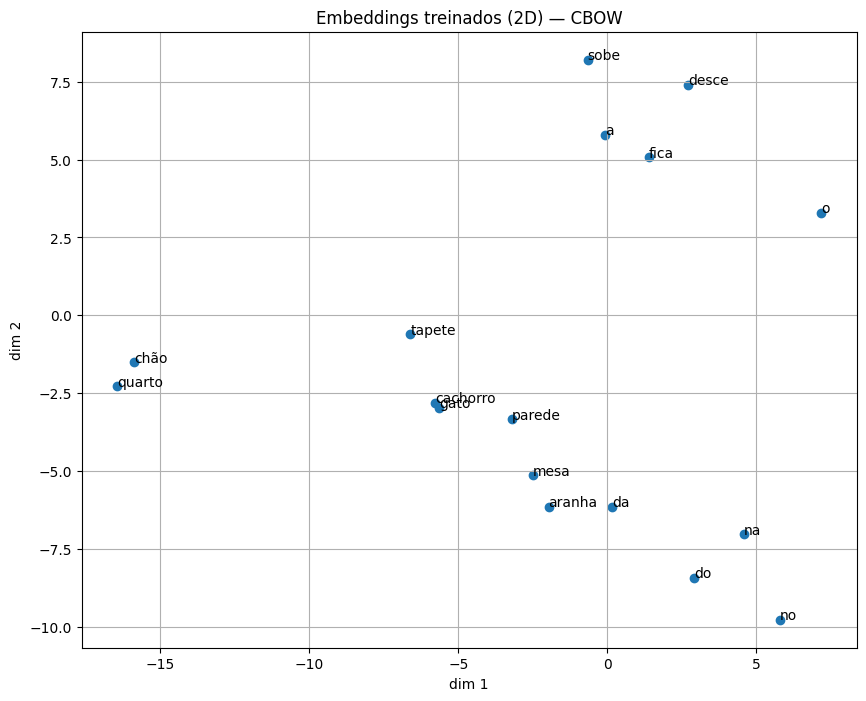

In [13]:
# Como embed_dim=2, podemos plotar direto
xs = emb_weights[:, 0].numpy()
ys = emb_weights[:, 1].numpy()

plt.figure(figsize=(10, 8))
plt.scatter(xs, ys)

for i, tok in enumerate(id_to_token):
    plt.annotate(tok, (xs[i], ys[i]), fontsize=10)

plt.title("Embeddings treinados (2D) — CBOW")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.grid(True)
plt.show()